**Uncomment the cell below if running on Google Colab or Kaggle**

In [ ]:
# %%capture
# !pip3 install -U torch torchvision torchaudio
# !pip3 install -U fastai

**Import dependencies**

In [1]:
from fastai.vision.all import *

In [2]:
import inspect
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def inspect_default_args(target, annotations: bool=False):
    # Get the argument names
    args = inspect.getfullargspec(target).args
    # Get the default values
    defaults = inspect.getfullargspec(target).defaults

    index = ["Default Value"]

    # Pad defaults
    defaults = [None]*(len(args)-len(defaults)) + list(defaults)
    if annotations:
        index.append("Annotation")
        annotations = inspect.getfullargspec(target).annotations.values()
        # Pad annotations
        annotations = [None]*(len(args)-len(annotations)) + list(annotations)
        default_args = {arg:[df, annot] for arg,df,annot in zip(args, defaults, annotations)}
    else:
        default_args = {arg:[default] for arg,default in zip(args, defaults)}
        
    return pd.DataFrame(default_args, index=index).T

In [3]:
from PIL import ImageDraw

def draw_point(img, x_coord, y_coord, radius=10, fill='red'):
    img_copy = img.copy()
    draw = ImageDraw.Draw(img_copy)
    draw.ellipse((x_coord, y_coord, x_coord+radius, y_coord+radius), fill='red')
    return img_copy

In [4]:
import torch

**Define path to dataset**

In [5]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [6]:
path.ls()

(#50) [Path('/home/innom-dt/.fastai/data/biwi_head_pose/01.obj'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/04'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/08.obj'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/09'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/18.obj'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/09.obj'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/04.obj'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/07.obj'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/22'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/24')...]

In [7]:
(path/'01').ls()

(#1000) [Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00249_rgb.jpg'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00357_pose.txt'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00492_rgb.jpg'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00282_rgb.jpg'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00200_rgb.jpg'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00301_rgb.jpg'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00223_pose.txt'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00441_pose.txt'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00338_pose.txt'),Path('/home/innom-dt/.fastai/data/biwi_head_pose/01/frame_00024_pose.txt')...]

**Get pose files**

In [8]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')

In [9]:
img_files = get_image_files(path)
img2pose(img_files[0])

Path('/home/innom-dt/.fastai/data/biwi_head_pose/04/frame_00249_pose.txt')

In [10]:
pose_file = str(img2pose(img_files[0]))
!cat $pose_file

0.85991 0.232345 -0.454501 
0.135574 0.754461 0.642191 
0.492113 -0.613844 0.617268 

181.698 -7.13897 1024.42 



(480, 640)


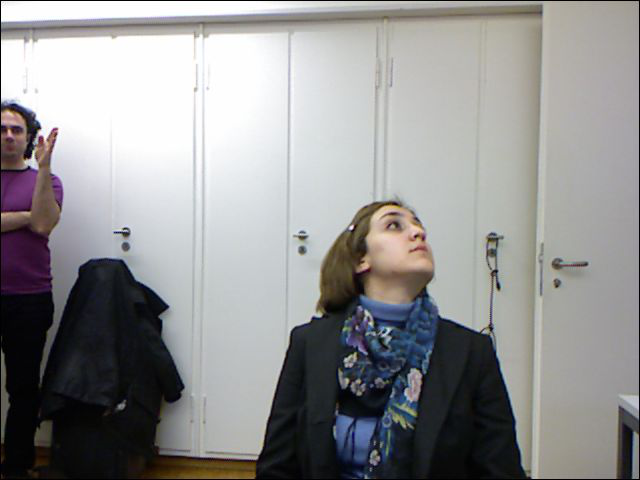

In [11]:
im = PILImage.create(img_files[0])
print(im.shape)
im

**Extract head center coordinates**

In [12]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])

In [13]:
ctr_coords = get_ctr(img_files[0])
ctr_coords

tensor([411.8190, 236.8924])

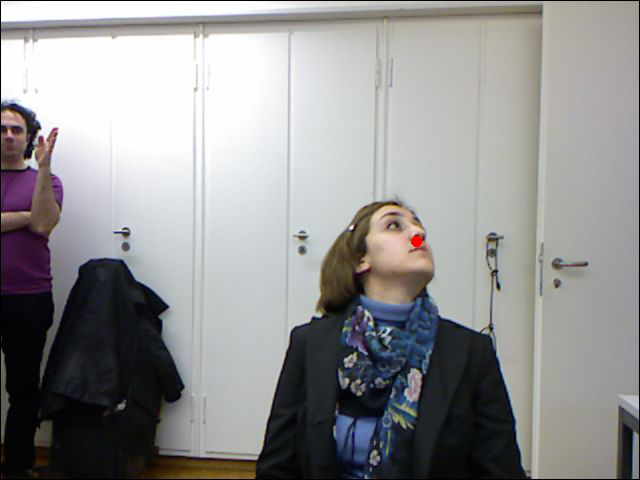

In [14]:
draw_point(im, ctr_coords[0], ctr_coords[1])

**Define batch size**

In [15]:
bs = 128

**Define Splitter**

In [16]:
# Use the samples for a single person as the validation set
splitter = FuncSplitter(lambda o: o.parent.name=='13')

**Define Transforms**

In [17]:
batch_tfms = [*aug_transforms(size=(240,320)), Normalize.from_stats(*imagenet_stats)]

**Define DataBlock**

In [18]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=splitter,
    batch_tfms=batch_tfms
)

**Define DataLoaders object**

In [19]:
dls = biwi.dataloaders(path, bs=bs)

**Verify DataLoaders object**

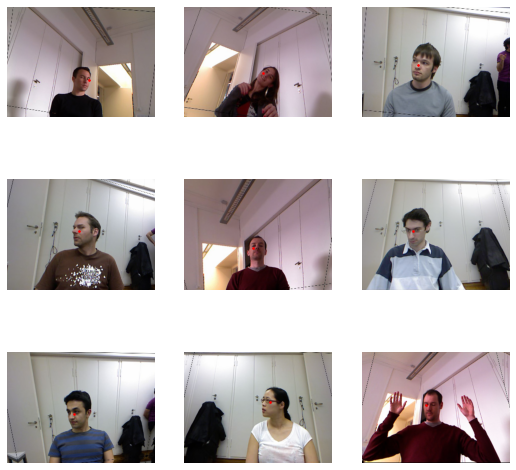

In [20]:
dls.show_batch()

**Inspect Learner parameters**

In [21]:
inspect_default_args(vision_learner)

,Default Value
dls,None
arch,None
normalize,True
n_out,None
pretrained,True
loss_func,None
opt_func,<function Adam at 0x7ff04d10a5f0>
lr,0.001
splitter,None
cbs,None


**Define model**

In [22]:
model = resnet18

**Define Learner object**

In [23]:
learn = vision_learner(dls, model, y_range=(-1,1)).to_fp16()

**Find learning rate**

In [24]:
inspect_default_args(learn.lr_find)

,Default Value
self,None
start_lr,0.0
end_lr,10
num_it,100
stop_div,True
show_plot,True
suggest_funcs,<function valley at 0x7ff04ce61750>


**Define [suggestion methods](https://docs.fast.ai/callback.schedule.html#Suggestion-Methods)**

In [25]:
suggest_funcs = [valley, minimum, steep]

SuggestedLRs(valley=0.001737800776027143, minimum=0.006918309628963471, steep=0.033113110810518265)

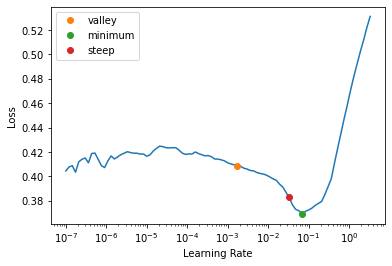

In [26]:
learn.lr_find(suggest_funcs=suggest_funcs)

**Define learning rate**

In [27]:
lr = 3e-3
lr

0.003

**Define number of epochs**

In [28]:
epochs = 4

**Fine tune model**

In [29]:
inspect_default_args(learn.fine_tune)

,Default Value
self,None
epochs,None
base_lr,0.002
freeze_epochs,1
lr_mult,100
pct_start,0.3
div,5.0
lr_max,None
div_final,100000.0
wd,None


In [30]:
learn.fine_tune(epochs, base_lr=lr)

epoch,train_loss,valid_loss,time
0,0.198777,0.011630,00:24


epoch,train_loss,valid_loss,time
0,0.019444,0.002721,00:26
1,0.005281,0.000477,00:26
2,0.002742,0.000511,00:27
3,0.002090,0.000231,00:26


**Select a test image**

In [31]:
import PIL

In [32]:
test_file = img_files[0]
test_file

Path('/home/innom-dt/.fastai/data/biwi_head_pose/04/frame_00249_rgb.jpg')

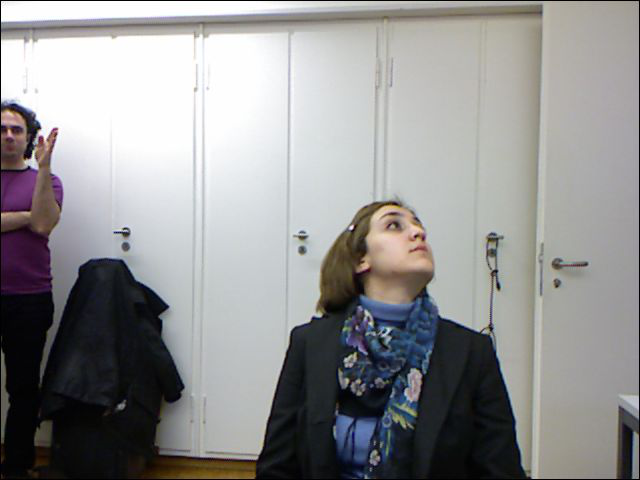

In [33]:
test_img = PIL.Image.open(test_file)
test_img

**Make a prediction on a single image using a file path**

In [34]:
learn.predict(test_file)

(TensorPoint([[202.5000, 115.3125]]),
 TensorBase([ 0.2656, -0.0391]),
 TensorBase([ 0.2656, -0.0391]))

**Make a prediction on a single image using a [fastai.vision.core.PILImage](https://docs.fast.ai/vision.core.html#PILImage)**

In [35]:
learn.predict(PILImage(test_img))

(TensorPoint([[202.5000, 115.3125]]),
 TensorBase([ 0.2656, -0.0391]),
 TensorBase([ 0.2656, -0.0391]))

**Make a prediction on a single image using a [fastai.torch_core.tensor](https://docs.fast.ai/torch_core.html#tensor)**

In [36]:
learn.predict(tensor(test_img))

(TensorPoint([[202.5000, 115.3125]]),
 TensorBase([ 0.2656, -0.0391]),
 TensorBase([ 0.2656, -0.0391]))

**Get Learner predictions**

In [37]:
predictions = learn.predict(tensor(test_img))

**Get input width**

In [38]:
dls.one_batch()[0].shape[2]

240

**Process predicted coords**

In [39]:
pred_coords = predictions[0][0]*(test_img.height/dls.one_batch()[0].shape[2])
pred_coords

TensorPoint([405.0000, 230.6250])

**Draw predicted coords on test image**

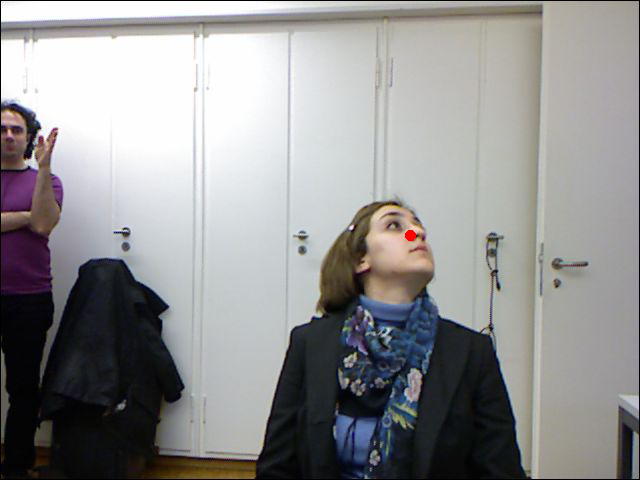

In [40]:
draw_point(test_img, pred_coords[0], pred_coords[1])

In [41]:
learn.dls.after_batch

Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': (240, 320), 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5} -> Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False} -> Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}

**Reset test image**

In [42]:
test_img = PIL.Image.open(test_file)

**Set input dims**

In [43]:
inp_dims = (320,240)

**Resize image**

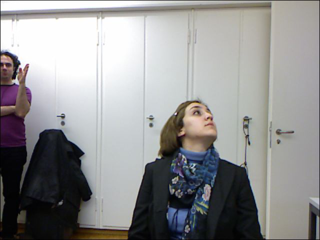

In [44]:
resized_img = test_img.resize(inp_dims)
resized_img

**Convert image to tensor**

In [45]:
img_tensor = tensor(resized_img).permute(2, 0, 1)
img_tensor.shape, img_tensor

(torch.Size([3, 240, 320]),
 tensor([[[ 67, 130, 126,  ...,  83,  89,  47],
          [132, 252, 245,  ..., 163, 167,  86],
          [131, 251, 242,  ..., 159, 165,  88],
          ...,
          [ 25,  19,  11,  ..., 129, 134,  75],
          [ 29,  32,  17,  ..., 133, 137,  75],
          [ 19,  21,  12,  ...,  66,  74,  39]],
 
         [[ 67, 130, 126,  ...,  78,  84,  43],
          [132, 252, 245,  ..., 158, 162,  81],
          [131, 251, 242,  ..., 154, 160,  83],
          ...,
          [ 17,  12,   5,  ..., 135, 135,  73],
          [ 21,  24,  10,  ..., 139, 138,  73],
          [ 10,  12,   4,  ...,  70,  74,  37]],
 
         [[ 67, 130, 126,  ...,  75,  81,  40],
          [132, 252, 245,  ..., 152, 157,  78],
          [131, 251, 242,  ..., 148, 155,  81],
          ...,
          [ 15,  10,   6,  ..., 137, 135,  72],
          [ 17,  20,   9,  ..., 140, 136,  72],
          [  6,   9,   4,  ...,  70,  73,  36]]], dtype=torch.uint8))

**Scale tensor values**

In [46]:
scaled_tensor = img_tensor.float().div_(255)

**Prepare imagenet mean values**

In [47]:
mean_tensor = tensor(imagenet_stats[0]).view(1,1,-1).permute(2, 0, 1)
mean_tensor.shape, mean_tensor

(torch.Size([3, 1, 1]),
 tensor([[[0.4850]],
 
         [[0.4560]],
 
         [[0.4060]]]))

**Prepare imagenet std values**

In [48]:
std_tensor = tensor(imagenet_stats[1]).view(1,1,-1).permute(2, 0, 1)
std_tensor.shape, std_tensor

(torch.Size([3, 1, 1]),
 tensor([[[0.2290]],
 
         [[0.2240]],
 
         [[0.2250]]]))

**Normalize and batch image tensor**

In [49]:
normalized_tensor = (scaled_tensor - mean_tensor) / std_tensor
batched_tensor = normalized_tensor.unsqueeze(dim=0)
batched_tensor.shape, batched_tensor

(torch.Size([1, 3, 240, 320]),
 tensor([[[[-0.9705,  0.1083,  0.0398,  ..., -0.6965, -0.5938, -1.3130],
           [ 0.1426,  2.1975,  2.0777,  ...,  0.6734,  0.7419, -0.6452],
           [ 0.1254,  2.1804,  2.0263,  ...,  0.6049,  0.7077, -0.6109],
           ...,
           [-1.6898, -1.7925, -1.9295,  ...,  0.0912,  0.1768, -0.8335],
           [-1.6213, -1.5699, -1.8268,  ...,  0.1597,  0.2282, -0.8335],
           [-1.7925, -1.7583, -1.9124,  ..., -0.9877, -0.8507, -1.4500]],
 
          [[-0.8627,  0.2402,  0.1702,  ..., -0.6702, -0.5651, -1.2829],
           [ 0.2752,  2.3761,  2.2535,  ...,  0.7304,  0.8004, -0.6176],
           [ 0.2577,  2.3585,  2.2010,  ...,  0.6604,  0.7654, -0.5826],
           ...,
           [-1.7381, -1.8256, -1.9482,  ...,  0.3277,  0.3277, -0.7577],
           [-1.6681, -1.6155, -1.8606,  ...,  0.3978,  0.3803, -0.7577],
           [-1.8606, -1.8256, -1.9657,  ..., -0.8102, -0.7402, -1.3880]],
 
          [[-0.6367,  0.4614,  0.3916,  ..., -0.4973, -

**Pass tensor to model**

In [50]:
with torch.no_grad():
    preds = learn.model(batched_tensor.cuda())
preds

TensorBase([[ 0.2706, -0.0312]], device='cuda:0')

**Process model output**

In [51]:
scaled_pred = ((preds[0].cpu()+1)/2) * tensor(inp_dims).float()
coords = scaled_pred * (test_img.width/inp_dims[0])
coords

TensorBase([406.5889, 232.5170])

**Draw predicted coords on test image**

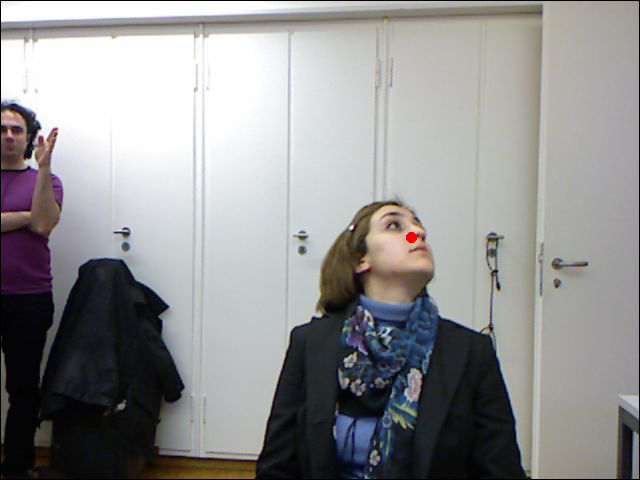

In [52]:
draw_point(test_img, coords[0], coords[1])

**Define ONNX file name**

In [53]:
onnx_file_name = f"{path.name}-{learn.arch.__name__}.onnx"
onnx_file_name

'biwi_head_pose-resnet18.onnx'

**Export trained model to ONNX**

In [54]:
torch.onnx.export(learn.model.cpu(),
                  batched_tensor,
                  onnx_file_name,
                  export_params=True,
                  opset_version=9,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  # Uncomment the line below to unlock input dimensions
                  #dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

**Note:** Might need to run the above cell twice in Google Colab for some reason.